In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

https://github.com/qubvel/segmentation_models.pytorch


## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = '/home/jn/data/testImages/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('no dir !!! ...')


In [4]:
x_images_dir = os.path.join(DATA_DIR, 'jpgDir')
y_images_dir = os.path.join(DATA_DIR, 'maskDir')


import itertools
def random_split(n, spilt):
    indices = np.random.permutation(n).tolist()
    lengths = [round(s*n) for s in spilt]
    if sum(lengths) != n:  # type: ignore
        raise ValueError("Sum of input split != the length of the input dataset!")

    ret = [ indices[offset - length : offset] for offset, length in zip(itertools.accumulate(lengths), lengths)]
    return ret

[train_idx, valid_idx, test_idx ] = random_split(len(os.listdir(x_images_dir)), [0.7,0.25,0.05])

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    CLASSES = ['sky', 'horizon']
    
    def __init__(
            self, 
            images_dir,
            masks_dir,
            indices=None,  # indices to use
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, os.path.splitext(image_id)[0]+'.png') for image_id in self.ids]
        if indices is None:
            self.indices = list(np.arange(len(self.ids)))
        else:
            self.indices = indices
        if max(self.indices) >= len(self.ids):  # type: ignore
            raise ValueError("Max of the indices list is > the length of the input dataset!")
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        idx = self.indices[i]
        image = cv2.imread(self.images_fps[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[idx], 0)//120   # to jn fix this
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.indices)

In [8]:
# ids = os.listdir(x_train_dir)
# images_fps = [os.path.join(x_train_dir, image_id) for image_id in ids]
# masks_fps = [os.path.join(y_train_dir, os.path.splitext(image_id)[0]+'.png') for image_id in ids]

In [9]:
dataset = Dataset(x_images_dir, y_images_dir, indices=train_idx , classes=['horizon'])
a = dataset[10]

In [10]:
# from torch.utils.data import random_split
# train, test = random_split(dataset, [60, 17])
# image, mask = train[4]
#

In [11]:
np.random.permutation(10)


array([0, 5, 8, 3, 9, 7, 4, 1, 6, 2])

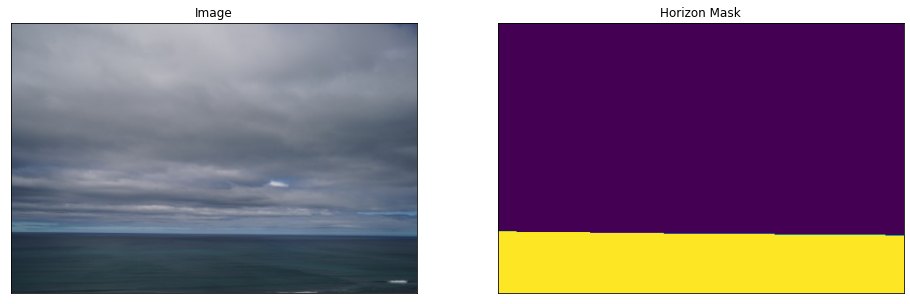

In [12]:
# Lets look at data we have

# dataset = Dataset(x_train_dir, y_train_dir, classes=['horizon'])
image, mask = dataset[7] # get some sample

# image, mask = dataset[4] # get some sample
visualize(
    image=image,
    horizon_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [13]:
import albumentations as albu

In [14]:
def get_training_augmentation():
    train_transform = [

        # albu.HorizontalFlip(p=0.5),
        #
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        # albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.GaussNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/jn/PycharmProjects/maui-object-tracker/venv/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/jn/PycharmProjects/maui-object-tracker/venv/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


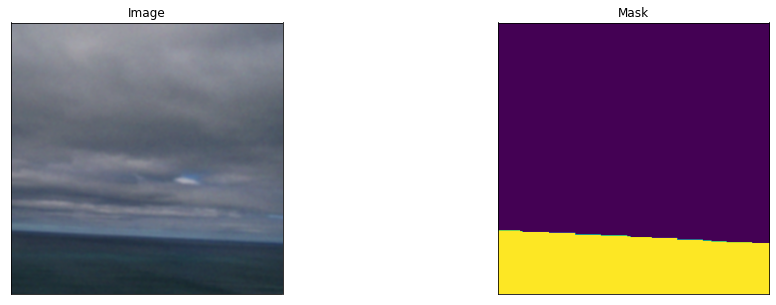

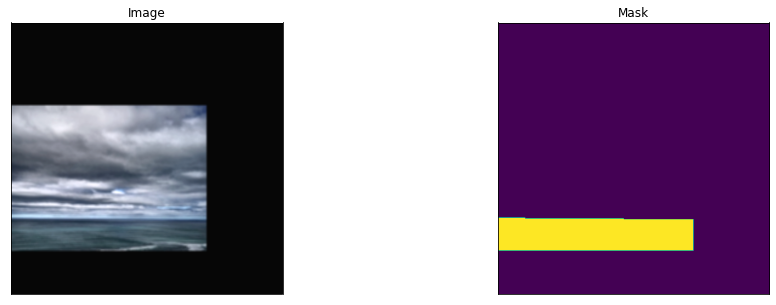

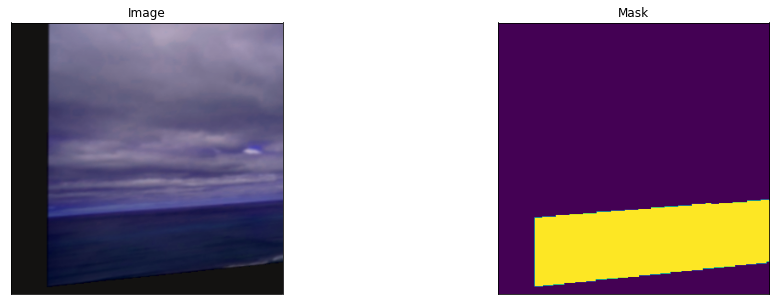

In [15]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_images_dir,
    y_images_dir,
    augmentation=get_training_augmentation(), 
    classes=['horizon'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [16]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [17]:
# https://paperswithcode.com/lib/timm/tf-mobilenet-v3
# ENCODER = 'se_resnext50_32x4d'
ENCODER = 'timm-mobilenetv3_small_075'  # 48 Million Flops
ENCODER = 'timm-mobilenetv3_large_100'  # 275 Million Flops
# ENCODER = 'timm-mobilenetv3_small_100'  # 65 Million Flops
# ENCODER = 'timm-mobilenetv3_large_075'   # 194 Million Flops
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['horizon']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [18]:
model.summary()

ModuleAttributeError: 'DeepLabV3' object has no attribute 'summary'

In [20]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

11020337

In [25]:
model_parameters = model.parameters()
params = sum([np.prod(p.size()) for p in model_parameters])
params


11020337

In [41]:
train_dataset = Dataset(
    x_images_dir,
    y_images_dir,
    indices=train_idx,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_images_dir,
    y_images_dir,
    indices=valid_idx,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


/home/jn/PycharmProjects/maui-object-tracker/venv/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/jn/PycharmProjects/maui-object-tracker/venv/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [44]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [45]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
train_logs = train_epoch.run(train_loader)

train: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s, dice_loss - 0.6247, iou_score - 0.3292]


In [46]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 25/25 [00:00<00:00, 33.37it/s, dice_loss - 0.2105, iou_score - 0.8712]
Model saved!

Epoch: 1
valid: 100%|██████████| 25/25 [00:00<00:00, 33.93it/s, dice_loss - 0.1702, iou_score - 0.943] 
Model saved!

Epoch: 2
valid: 100%|██████████| 25/25 [00:00<00:00, 36.18it/s, dice_loss - 0.1471, iou_score - 0.9506]
Model saved!

Epoch: 3
valid: 100%|██████████| 25/25 [00:00<00:00, 36.50it/s, dice_loss - 0.1409, iou_score - 0.9126]

Epoch: 4
valid: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s, dice_loss - 0.1244, iou_score - 0.9443]

Epoch: 5
valid: 100%|██████████| 25/25 [00:00<00:00, 35.42it/s, dice_loss - 0.1287, iou_score - 0.947] 

Epoch: 6
valid: 100%|██████████| 25/25 [00:00<00:00, 35.01it/s, dice_loss - 0.1381, iou_score - 0.9394]

Epoch: 7
valid: 100%|██████████| 25/25 [00:00<00:00, 35.30it/s, dice_loss - 0.1224, iou_score - 0.9615]
Model saved!

Epoch: 8
valid: 100%|██████████| 25/25 [00:00<00:00, 35.53it/s, dice_loss - 0.1072, iou_score - 0.9716]
Mod

## Test best saved model

In [47]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [48]:
# create test dataset
test_dataset = Dataset(
    x_images_dir,
    y_images_dir,
    indices=test_idx,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [49]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 5/5 [00:00<00:00, 35.73it/s, dice_loss - 0.04355, iou_score - 0.9954]


## Visualize predictions

In [50]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_images_dir, y_images_dir,
    indices=test_idx,
    classes=CLASSES,

)

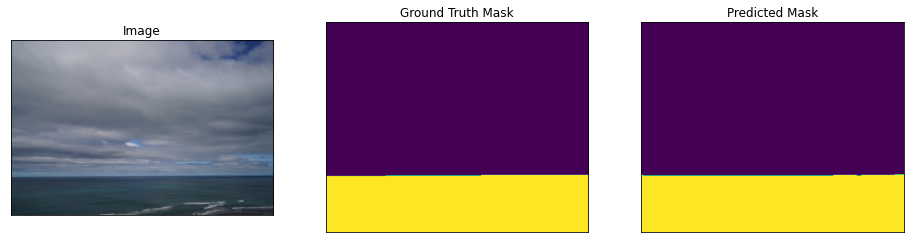

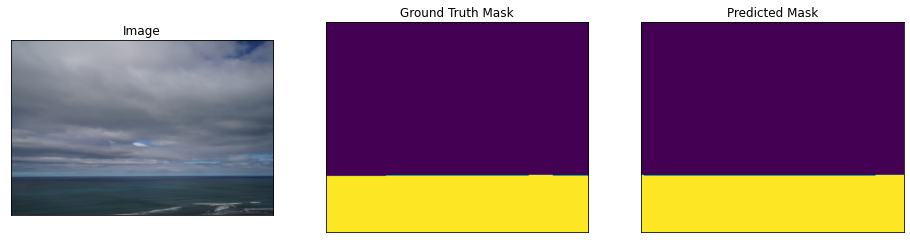

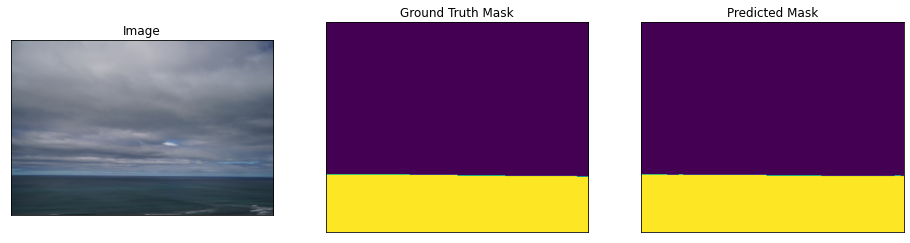

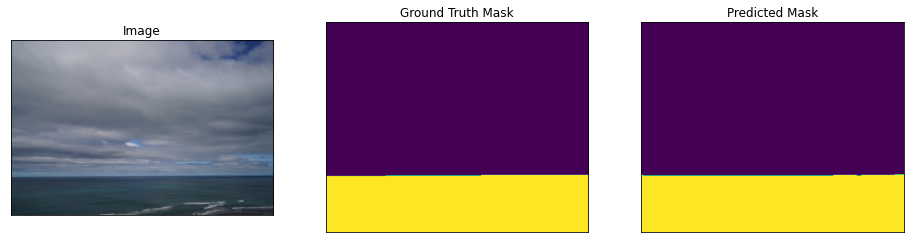

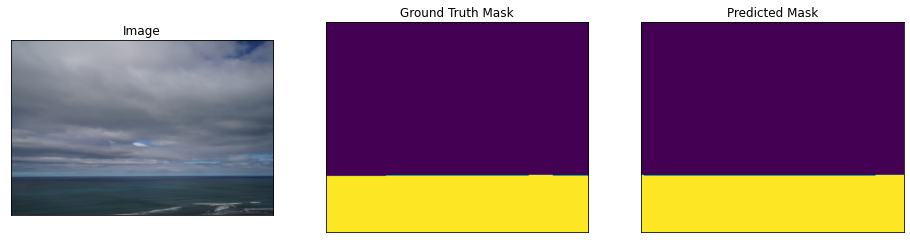

In [51]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    # image, gt_mask = train_dataset[n]

    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

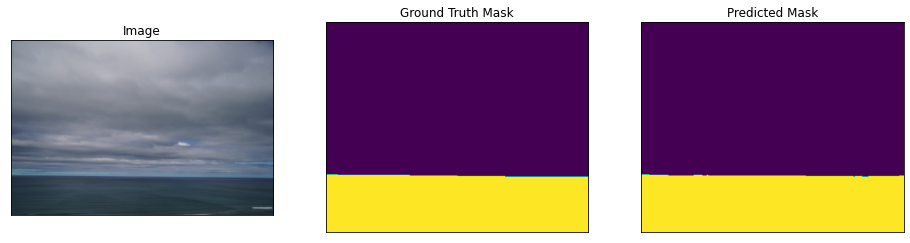

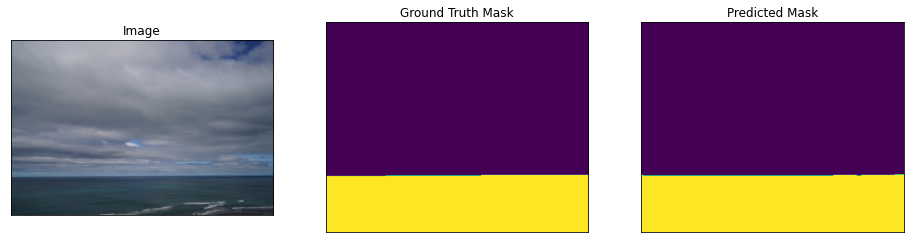

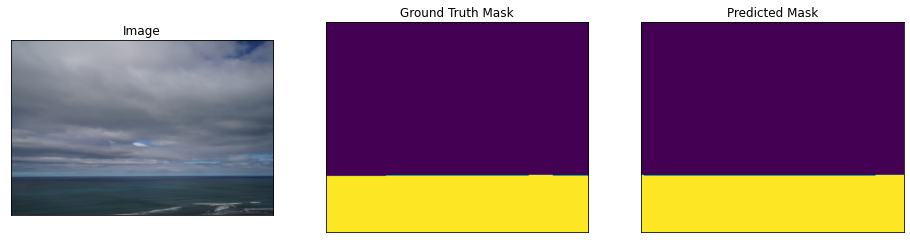

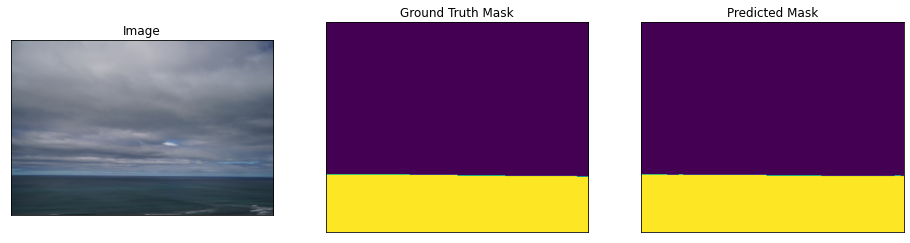

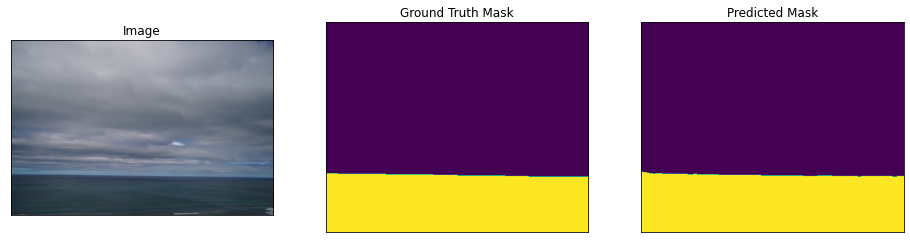

In [52]:
DEVICE = 'cpu'
best_model.to(DEVICE)
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )

In [53]:
%timeit best_model.predict(x_tensor)

252 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
x_tensor.shape

torch.Size([1, 3, 384, 480])

### Smaller segments for speed

In [ ]:
x_tensor2 = x_tensor[0,:,192:, 192:384].unsqueeze(0)
# x_tensor2.shape
pr_mask = best_model.predict(x_tensor2)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
visualize(
    image=image_vis,
    ground_truth_mask=gt_mask,
    predicted_mask=pr_mask
    )

In [72]:
%timeit best_model.predict(x_tensor2)

46.9 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
